# Testing our Data Infrastructure.

In this notebook, we test that the Data library is working as proposed. When we call get pricing on a list of symbols or a singleton symbol a Pandas Datafram or Series should be returned respectively.

In [6]:
import time
import datetime
import random
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scraper
import retrieve_data

# This creates a get_pricing function that uses Alpha Vantage as a source for data and my MySQL database
# for data storage and retrieval
pipeline = retrieve_data.PricePipeline()
get_pricing = pipeline.get_pricing


We can load the dictionaries that take Industries and Sectors to their S&P500 constituent stocks from our json file that was generated using the scraper.py 

In [6]:
with open('industry_to_stocks') as f:
    industry_to_stocks = json.load(f)

with open('sector_to_stocks') as f:
    sector_to_stocks = json.load(f)
    
with open('sp500') as f:
     sp500 = json.load(f)

with open('date_joined') as f:
    symbol_to_date_joined = json.load(f)

If this is out-of-date, uncomment and use the following:

In [7]:
# sp500 = scraper.sp500
# symbol_to_date_joined = scraper.symbol_to_date_joined
# sector_to_stocks = scraper.sector_to_stocks
# industry_to_stocks = scraper.industry_to_stocks

# # You can use the following code to store these dictionaries as JSON files for future use and import them using
# # the code in the cell above.

# with open('sector_to_stocks', 'w') as f:
#     json.dump(sector_to_stocks, f)

# with open('industry_to_stocks', 'w') as f:
#     json.dump(industry_to_stocks, f)

# with open('sp500', 'w') as f:
#     json.dump(sp500, f)

# with open('date_joined', 'w') as f:
#     json.dump(symbol_to_date_joined, f)

We will now test that our retrieval and storage system works. First we get the list of airline stocks in the S&P500 to inspect.

In [8]:
start_date = "2016-01-01"
end_date = "2016-12-31"
airlines = industry_to_stocks["Airlines"]
print(airlines)

['ALK', 'AAL', 'DAL', 'LUV', 'UAL']


The function ```relevant_symbols``` as defined below removes stocks that weren't actually part of the S&P500 before the dates we we're interested in. We use this to avoid some data leakage/look-ahead bias (Stocks that weren't in the S&P500 are likely to have risen in price before they were added).

Notice how 'ALK' is removed from the list because it joined the S&P500 after 2016-01-01.

In [9]:
def joined_before_date(symbol, start_date):
    join_date = symbol_to_date_joined[symbol]
    if join_date == '':
        return False
    return time.strptime(join_date, "%Y-%m-%d") <= time.strptime(start_date, "%Y-%m-%d")

def relevant_symbols(symbols, start_date):
    new_symbols = []
    for symbol in symbols:
        if joined_before_date(symbol, start_date):
            new_symbols.append(symbol)
    return new_symbols

airlines = relevant_symbols(airlines, start_date)
print(airlines)

['AAL', 'DAL', 'LUV', 'UAL']


We can now use the `get_pricing` function to return a dataframe containing the daily price data for these stocks between our two given dates. Since I have this in my database already, the function returns the data from a query database. If it wasn't, the data would download from a source, stored in the database, and "Downloading:" would be printed instead of "From db:".

In [10]:
prices_2016 = get_pricing(airlines, start_date, end_date)
prices_2016.head()

From db: AAL
From db: DAL
From db: LUV
From db: UAL


,AAL,DAL,LUV,UAL
date,,,,
2016-01-04,39.0926,44.2305,40.0897,55.61
2016-01-05,38.7199,44.1487,40.5674,55.06
2016-01-06,39.3984,44.4759,40.9400,55.20
2016-01-07,38.6530,42.7216,40.0801,52.63
2016-01-08,38.5766,42.3671,40.3285,51.89


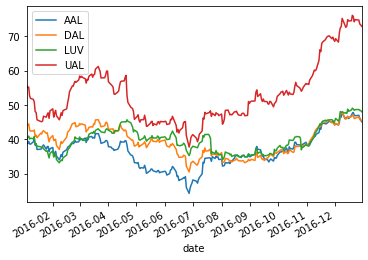

In [11]:
prices_2016.plot()
plt.legend()

Now, we test that the function can accept singletons and can download and store new data. Note that if we call `get_pricing` a second time on the same symbol, it retrieves the desired data from the database instead of downloading it.

In [12]:
get_pricing("PPL", start_date, end_date).head()

Downloading: PPL


date
2016-12-30    28.4359
2016-12-29    28.6113
2016-12-28    28.2772
2016-12-27    28.5695
2016-12-23    28.6363
Name: PPL, dtype: float64

In [13]:
PPL = get_pricing("PPL", start_date, end_date)
PPL.head()

From db: PPL


,PPL
date,
2016-01-04,26.9554
2016-01-05,27.2435
2016-01-06,27.1554
2016-01-07,26.8433
2016-01-08,26.7233
